In [23]:
!pip install -q langchain langgraph cassio dotenv langchain_community langchain_groq chromadb tiktoken langchain_huggingface sentence_transformers langchain_openai 

In [17]:
#!pip install -q --upgrade transformers deepspeed sentence-transformers langchain


In [16]:
#!pip install deepspeed==0.9.5


In [2]:
import cassio
from dotenv import load_dotenv
import os
load_dotenv()
#provide connection of the AstraDB
ASTRA_DB_APPLICATION_TOKEN=os.getenv('ASTRA_DB_TOKEN')
ASTRA_DB_ID="53ed12c4-7e9d-4a83-8b47-9e44a9a27ed2"

In [3]:
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

In [4]:
#Build Index
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls=[
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

docs=[WebBaseLoader(url).load()for url in urls]
docs_list=[item for sublist in docs for item in sublist]
#text_splitter=RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_split=text_splitter.split_documents(docs_list)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
#docs_list

In [6]:
#doc_split

In [20]:
from langchain_openai import OpenAIEmbeddings
embeddings=OpenAIEmbeddings(model="text-embedding-3-large")

In [28]:
from langchain.vectorstores.cassandra import Cassandra
astra_vectore_db=Cassandra(embedding=embeddings,
                           table_name="qa_mini",
                           session=None, keyspace=None)

In [34]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vectore_db.add_documents(doc_split)
print("Inserted", len(doc_split))

Inserted 89


In [40]:
astra_vector_index=VectorStoreIndexWrapper(vectorstore=astra_vectore_db)

In [44]:
retriever=astra_vectore_db.as_retriever()
#retriever.invoke("What is reward hacking?")

In [65]:
#creating the router 
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
#router 
class RouteQuery(BaseModel):
    """ Route a quser query to the most relevant data source """
    datasource: Literal["vectorstore","wiki_search"]=Field(
        ...,
        description="Given a user question choose to route it to wikipedia or the vectorstore"
    )
    
    

In [72]:
from langchain_groq import ChatGroq
import os
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
llm=ChatGroq(model_name="Gemma2-9b-It")

In [73]:
structured_llm_router=llm.with_structured_output(RouteQuery)

In [74]:
system=""" You are an expert at routing user questions between vectorstore or wikipedia tool
Based on the questions asked please do the required routing"""
route_prompt=ChatPromptTemplate.from_messages(
    [
     ("system",system),
        ("human","{question}"),
    ]
)

In [75]:
question_router=route_prompt | structured_llm_router

In [76]:
#!pip -q install wikipedia

In [77]:
print(question_router.invoke({"question": "Who is sharukh khan?"}))

datasource='wiki_search'


In [ ]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [78]:
wiki.run("Halo")

'Page: Halo (franchise)\nSummary: Halo is a military science fiction video game series and media franchise, originally developed by Bungie and currently managed and developed by Halo Studios (previously'

In [81]:
## Langgraph application
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    
    question: str
    generation:str
    documents: List[str]

In [82]:
from langchain.schema import Document
def retrieve(state):
    """Retrieve documents
    Args: Current graph state
    
    Returns state: new key added to state that contains retrieved docs"""
    
    print("---Retrieve---")
    questions=state["question"]
    #retrieval
    
    documents=retriever.invoke(questions)
    return {"documents":documents,"questions":questions}

In [83]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [84]:

def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [96]:
from langgraph.graph import END, StateGraph, START
workflow=StateGraph(GraphState)
#define nodes
workflow.add_node("wiki_search",wiki_search)
workflow.add_node("retrieve",retrieve)

#build the graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search":"wiki_search",
        "vectorstore": "retrieve",
    }
)

workflow.add_edge("retrieve",END)
workflow.add_edge("wiki_search",END)

In [99]:
#compile the graph
graph=workflow.compile()

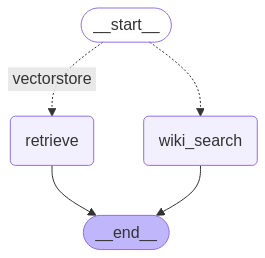

In [100]:
graph

In [105]:
from langchain_core.messages import HumanMessage

while True:
    user_input=input("User:")
    if user_input.lower() in ["quit","q"]:
        print("Good Bye")
        break
    for event in graph.stream({'question': user_input}):
        #print(event.values())
        for value in event.values():
               print("Assistant:",value.get("answer") or value)

User: hi


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---Retrieve---
Assistant: {'documents': [Document(id='660830a175ff4abb8741a6f3bd35a19c', metadata={'description': 'Diffusion models have demonstrated strong results on image synthesis in past years. Now the research community has started working on a harder task—using it for video generation. The task itself is a superset of the image case, since an image is a video of 1 frame, and it is much more challenging because:\n\nIt has extra requirements on temporal consistency across frames in time, which naturally demands more world knowledge to be encoded into the model.\nIn comparison to text or images, it is more difficult to collect large amounts of high-quality, high-dimensional video data, let along text-video pairs.\n\n\n\nğŸ¥‘ Required Pre-read: Please make sure you have read the previous blog on “What are Diffusion Models?” for image generation before continue here.\n', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2

User: what is diffusion video


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---Retrieve---
Assistant: {'documents': [Document(id='9bee944f879b48ac9bd44d205b0e8c9c', metadata={'description': 'Diffusion models have demonstrated strong results on image synthesis in past years. Now the research community has started working on a harder task—using it for video generation. The task itself is a superset of the image case, since an image is a video of 1 frame, and it is much more challenging because:\n\nIt has extra requirements on temporal consistency across frames in time, which naturally demands more world knowledge to be encoded into the model.\nIn comparison to text or images, it is more difficult to collect large amounts of high-quality, high-dimensional video data, let along text-video pairs.\n\n\n\nğŸ¥‘ Required Pre-read: Please make sure you have read the previous blog on “What are Diffusion Models?” for image generation before continue here.\n', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2

KeyboardInterrupt: Interrupted by user